In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import soec_standalone_flowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = soec_standalone_flowsheet.SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:17:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")

2022-12-02 17:17:33 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Starting initialization
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Starting initialization
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Property initialization: optimal - Optimal Solution Found.
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side: Initialization Complete
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Starting initialization
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-02 17:17:34 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_out: Starting initialization
2022-12-02 17:17:34 [INFO] idae

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-02 17:18:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

In [9]:
solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp919ayxrl_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp919ayxrl_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2443, 'Number of variables': 2443, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 1.2491934299468994}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    for hx in [m.fs.water_evaporator01, m.fs.water_evaporator02]:
            try:
                tdew = hx.shell.properties_out[0].temperature_dew["Liq", "Vap"]
            except KeyError:
                tdew = hx.shell.properties_out[0].temperature_dew["Vap", "Liq"]

            @hx.shell.Constraint(m.fs.time)
            def no_condensation_eqn(b, t):
                return b.properties_out[0].temperature >= tdew
            iscale.constraint_scaling_transform(hx.shell.no_condensation_eqn[0], 1e-2)
            
    for hx in [m.fs.water_evaporator03, m.fs.water_evaporator04, m.fs.water_preheater]:
        for t in m.fs.time:
            try:
                eps = hx.hot_side.properties_in[t].eps_2_Liq_Vap
            except (KeyError, idaes_except.PropertyNotSupportedError):
                eps = hx.hot_side.properties_in[t].eps_2_Vap_Liq
            eps = 1e-3
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.3))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (625+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    #set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-8000,8000))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
    
    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_1(b, t):
        return (b.soec_module.fuel_outlet.temperature[t] - b.soec_module.fuel_inlet.temperature[t]) <= 50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_2(b, t):
        return (b.soec_module.fuel_outlet.temperature[t] - b.soec_module.fuel_inlet.temperature[t]) >= -50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_3(b, t):
        return (b.soec_module.oxygen_outlet.temperature[t] - b.soec_module.oxygen_inlet.temperature[t]) <= 50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_4(b, t):
        return (b.soec_module.oxygen_outlet.temperature[t] - b.soec_module.oxygen_inlet.temperature[t]) >= -50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_5(b, t):
        return (b.soec_module.fuel_outlet.temperature[t] - b.soec_module.oxygen_inlet.temperature[t]) <= 50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_6(b, t):
        return (b.soec_module.fuel_outlet.temperature[t] - b.soec_module.oxygen_inlet.temperature[t]) >= -50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_7(b, t):
        return (b.soec_module.oxygen_outlet.temperature[t] - b.soec_module.fuel_inlet.temperature[t]) <= 50

    @m.fs.Constraint(m.fs.time)
    def thermal_gradient_eqn_8(b, t):
        return (b.soec_module.oxygen_outlet.temperature[t] - b.soec_module.fuel_inlet.temperature[t]) >= -50

    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_1[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_2[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_3[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_4[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_5[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_6[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_7[0],1e-2)
    iscale.constraint_scaling_transform(m.fs.thermal_gradient_eqn_8[0],1e-2)
    
    @m.fs.Constraint(m.fs.time)
    def average_current_density_constraint(b, t):
        return m.fs.soec_module.solid_oxide_cell.average_current_density[0]/1000 >= -8
    
    @m.fs.Constraint(m.fs.time)
    def sweep_min_concentration_eqn(b,t):
        return b.sweep_recycle_split.inlet.mole_frac_comp[t,"O2"] >= 0.25 
    @m.fs.Constraint(m.fs.time)
    def sweep_max_concentration_eqn(b,t):
        return b.sweep_recycle_split.inlet.mole_frac_comp[t,"O2"] <= 0.35 
    
    @m.fs.Constraint(m.fs.time)
    def min_h2_feed_eqn(b,t):
        return b.feed_recycle_mix.outlet.mole_frac_comp[t,"H2"] >= 0.05
    
    @m.fs.Constraint(m.fs.time)
    def water_utilization(b, t):
        return (b.water_demand[t] - b.water_recycle[t]) <= 10475 * pyo.units.mol/pyo.units.s
    
    iscale.constraint_scaling_transform(m.fs.water_utilization[0], 1e-4)
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

In [11]:
#set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-8000,8000))
#m.fs.average_current_density_constraint.deactivate()
m.fs.h2_mass_production.fix(5)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp5tegy1x7_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp5tegy1x7_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  68  5.3920907e+02 1.99e-02 4.84e+10  -5.7 2.75e+00    -  7.10e-03 6.30e-01f  1
  69  5.3907135e+02 1.24e-01 6.37e+11  -5.7 4.33e+00    -  1.72e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.3896305e+02 1.68e-01 3.67e+11  -5.7 8.51e+00    -  8.14e-01 4.23e-01h  1
  71  5.3861870e+02 1.15e+00 1.95e+03  -5.7 1.19e+01    -  1.00e+00 1.00e+00h  1
  72  5.3859674e+02 1.12e+00 6.93e+05  -5.7 2.80e+01    -  5.04e-01 3.04e-02h  1
  73  5.3828932e+02 2.36e+00 1.07e+06  -5.7 2.77e+01    -  1.00e+00 4.38e-01h  1
  74  5.3818332e+02 2.63e+00 1.54e+05  -5.7 3.64e+01    -  4.97e-01 1.81e-01h  1
  75  5.3818332e+02 2.63e+00 1.57e+05  -5.7 1.07e+02    -  3.17e-02 3.03e-06h  2
  76  5.3816271e+02 3.31e+00 1.80e+05  -5.7 1.02e+02    -  9.31e-03 5.35e-02h  1
  77  5.3816382e+02 3.20e+00 3.52e+05  -5.7 2.20e+00  -0.4 8.17e-04 3.21e-02h  1
  78  5.3816658e+02 3.05e+00 1.31e+05  -5.7 7.61e-01  -0.9 9.26e-02 4.62e-02h  1
  79  5.3817184e+02 2.90e+00

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2458, 'Number of variables': 2462, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 13.675074100494385}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
pyo.value((m.fs.obj)*1e6/(5*m.fs.costing.plant_uptime))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2960943256 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower : Value               : Upper : Fixed : Stale : Domain
     (0.0, 1) :  None : -7050.3533676828965 :  None : False : False :  Reals
     (0.0, 2) :  None :   -8372.05166852456 :  None : False : False :  Reals
     (0.0, 3) :  None :   -9311.57728127942 :  None : False : False :  Reals
     (0.0, 4) :  None :  -9707.174291809475 :  None : False : False :  Reals
     (0.0, 5) :  None :  -9578.775482962012 :  None : False : False :  Reals
     (0.0, 6) :  None :  -9029.279173602883 :  None : False : False :  Reals
     (0.0, 7) :  None :   -8198.83045313985 :  None : False : False :  Reals
     (0.0, 8) :  None : -7226.6647693720915 :  None : False : False :  Re

3.4109267737334394

In [13]:
display_soec_costing(m.fs)

Capital cost: $484M
Fixed O&M cost: $27.9M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


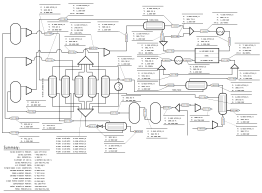

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,855.23397,100.0,183.594791
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,855.23397,NaN,183.569074
feed03,61.410986,4.166204,NaN,NaN,20.469574,79.530426,NaN,NaN,1.2,882.708718,NaN,254.708625
feed04,61.410986,4.166204,NaN,NaN,20.469574,79.530426,NaN,NaN,1.2,931.725712,NaN,268.87747
hstrm01,21.729984,4.166204,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,981.725712,NaN,283.430957
hstrm02,5.560044,1.066005,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,981.725712,NaN,72.521387
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,981.725712,NaN,210.909571
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,545.181733,NaN,117.10687
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,477.507463,NaN,102.558506


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
                 #m.fs.product_flash02,
                 m.fs.product_flash03, m.fs.product_flash04]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

# tpc = pyo.value(m.fs.costing.total_TPC)
# tasc = tpc*1.21*1.093
# ac = tasc*0.0707
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

# Parameters
# n_op = 6.3
# hourly_rate = 38.50
# labor_burden = 30

# Fixed O&M components
# annual_op_labor = n_op * hourly_rate * 8760 * (1 - labor_burden/100)/1e6
# maint_labor = tpc * 0.4 * 0.019 
# maint_material = tpc * 0.6 * 0.019
# admin_labor = 0.25*(annual_op_labor + maint_labor)
# prop_tax_ins = 0.02*tpc
# soec_replace = pyo.value(4.2765*m.fs.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $484.06MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $26.30MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $22.30MM
Contribution from gas-gas exchangers: $23.22MM
Contribution from gas-water exchangers: $31.36MM
Contribution from flash vessels: $0.32MM
Contribution from heat pump: $32.08MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $65.20MM
Contribution from accessory electric equipment: $102.89MM
Contribution from instrumentation and controls: $23.88MM
Contribution from improvements to site: $27.48MM
Contribution from buildings and structures: $7.35MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 484.0572356002262
TASC = 640.1802157983672
Annualized TASC (MM$/yr) = 45.260741256944556
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.678834990561719
maint_ma

In [18]:
for hx in water_heaters + cross_flow_exchangers:
    print(hx)
    hx.area.display()
    hx.area.fix()
m.fs.soec_module.number_cells.fix()
m.fs.soec_module.number_cells.display()

print(m.fs.feed_recycle_split)
m.fs.feed_recycle_split.split_fraction.display()
print(m.fs.sweep_recycle_split)
m.fs.sweep_recycle_split.split_fraction.display()
print(m.fs.sweep_blower)
m.fs.sweep_blower.inlet.flow_mol.display()
m.fs.feed_heater.outlet.temperature.display()
m.fs.sweep_heater.outlet.temperature.display()
m.fs.soec_module.potential_cell.display()

fs.water_evaporator01
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   400 : 400.0 :  None : False : False : PositiveReals
fs.water_evaporator02
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :   400 : 400.0000132375149 :  None : False : False : PositiveReals
fs.water_evaporator03
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :   400 : 3183.670460299069 :  None : False : False : PositiveReals
fs.water_evaporator04
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :   400 : 6195.831055328262 :  None : False : False : PositiveReals
fs.water_evaporator05
area : Heat exchange area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Va

In [ ]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()
    
m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )    

In [ ]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal
        assert res.solver.status == pyo.SolverStatus.ok
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1

In [ ]:
if df is not None:
    df.to_csv("soec.csv")

In [ ]:
display(SVG(m.fs.write_pfd()))

In [ ]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03, m.fs.product_flash04]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

In [ ]:
m.fs.soec_module.solid_oxide_cell.temperature_z.pprint()

In [ ]:
print(df)

In [ ]:
pyo.value(m.fs.product_flash01.liq_outlet.flow_mol[0])

In [ ]:
m.fs.sweep_hot_exchanger.report()
pyo.value(m.fs.sweep_hot_exchanger.costing.total_plant_cost)

In [ ]:
m.fs.sweep_hot_exchanger.costing.total_plant_cost.pprint()

In [ ]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [ ]:
variables, constraints, jac, dh = check_scaling(m.fs)

In [ ]:
m.fs.product_flash05.report()

In [ ]:
[j for j, var in enumerate(variables) if var.name == "fs.product_flash01.control_volume.properties_out[0.0].flow_mol_phase[Liq]"]


In [ ]:
col = jac.getcol(1178)

In [ ]:
print(col)

In [ ]:
constraints[1428].name

In [ ]:
jac, nlp = iscale.get_jacobian(m.fs, scaled=True, equality_constraints_only=True)

In [ ]:
jac = jac[0]

In [ ]:
variables = nlp.get_pyomo_variables()
constraints = nlp.get_pyomo_equality_constraints()

In [ ]:
dh.check_residuals(1e-5)

In [ ]:
m.fs.feed_hot_exchanger.report()

In [ ]:
m.fs.water_preheater.report()